In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [3]:
file_name = 'stat_0602'

stat = pd.read_csv('stat/' + file_name + '.csv')
train = pd.read_csv('data/train.csv', usecols=['bidder_id', 'outcome'])
test = pd.read_csv('data/test.csv', usecols=['bidder_id'])

In [4]:
stat = pd.merge(stat, train, on='bidder_id', how='left')
stat.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6614 entries, 0 to 6613
Data columns (total 138 columns):
bidder_id                  6614 non-null object
bid_count                  6614 non-null int64
bid_count_auc_mean         6614 non-null float64
bid_count_auc_std          6614 non-null float64
bid_count_auc_max          6614 non-null int64
bid_count_ip_mean          6614 non-null float64
bid_count_ip_std           6614 non-null float64
bid_count_ip_max           6614 non-null int64
bid_count_url_mean         6614 non-null float64
bid_count_url_std          6614 non-null float64
bid_count_url_max          6614 non-null int64
bid_lst100_mean            3851 non-null float64
bid_lst100_std             3009 non-null float64
bid_lst100_max             3851 non-null float64
bid_lst100_min             3851 non-null float64
first_bid_count            1469 non-null float64
last_bid_count             1426 non-null float64
last_2nd_bid_count         1398 non-null float64
auc_nuni           

In [5]:
stat.loc[:, stat.isnull().any()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6614 entries, 0 to 6613
Data columns (total 18 columns):
bid_lst100_mean           3851 non-null float64
bid_lst100_std            3009 non-null float64
bid_lst100_max            3851 non-null float64
bid_lst100_min            3851 non-null float64
first_bid_count           1469 non-null float64
last_bid_count            1426 non-null float64
last_2nd_bid_count        1398 non-null float64
t_resp_min                6610 non-null float64
t_resp_max                6610 non-null float64
t_resp_mean               6610 non-null float64
t_resp_std                6610 non-null float64
t_resp_median             6610 non-null float64
t_resp_auc_mean_mean      6610 non-null float64
t_resp_auc_mean_std       6610 non-null float64
t_resp_auc_median_mean    6610 non-null float64
t_resp_auc_median_std     6610 non-null float64
t_resp_auc_std_mean       4490 non-null float64
outcome                   1984 non-null float64
dtypes: float64(18)
memory us

In [6]:
# preprocessing
bidder = stat['bidder_id']
clr_stat = stat.drop(['bidder_id', 'outcome'], axis=1)
clr_stat.fillna(0, inplace=True)

numbers = clr_stat.select_dtypes(exclude=['object'])
num_col_name = numbers.columns
numbers = numbers.as_matrix()

texts = clr_stat.select_dtypes(include=['object']).as_matrix()

scaler = StandardScaler()
numbers = pd.DataFrame(data=scaler.fit_transform(numbers), columns=num_col_name)

mlb = MultiLabelBinarizer()
mlb.fit(texts)
text_col_name = mlb.classes_
texts = pd.DataFrame(data=mlb.transform(texts), columns=text_col_name)

clr_stat = pd.concat([numbers, texts], axis=1)
clr_stat['bidder_id'] = bidder

In [7]:
train_sheet = pd.merge(clr_stat, train, on='bidder_id')
test_sheet = pd.merge(clr_stat, test, on='bidder_id')
y = train_sheet['outcome']
X = train_sheet.drop(['bidder_id', 'outcome'], axis=1)

# KNN

Best predict score for random state 15: 0.8295739348370926
Best parameter n_neighbors: 75
Best predict score for random state 233: 0.7924819319583994
Best parameter n_neighbors: 37
Best predict score for random state 1024: 0.7707417179712694
Best parameter n_neighbors: 33


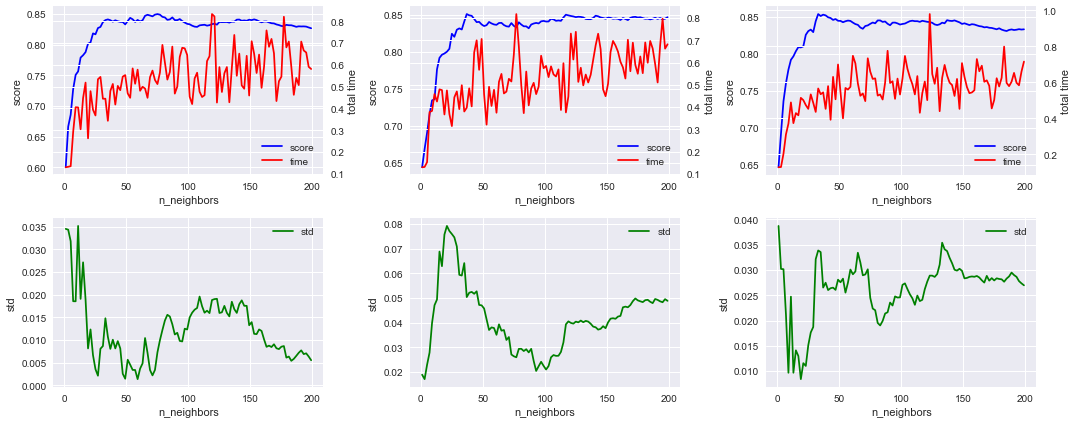

In [16]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    knn = KNeighborsClassifier(n_jobs=-1)
    parameters = {
        'n_neighbors': range(1, 200, 2)
    }
    cv = GridSearchCV(knn, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'n_neighbors'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.820036201615149
Best parameter weights: distance
Best predict score for random state 233: 0.7997532169927728
Best parameter weights: distance
Best predict score for random state 1024: 0.8153034300791556
Best parameter weights: distance


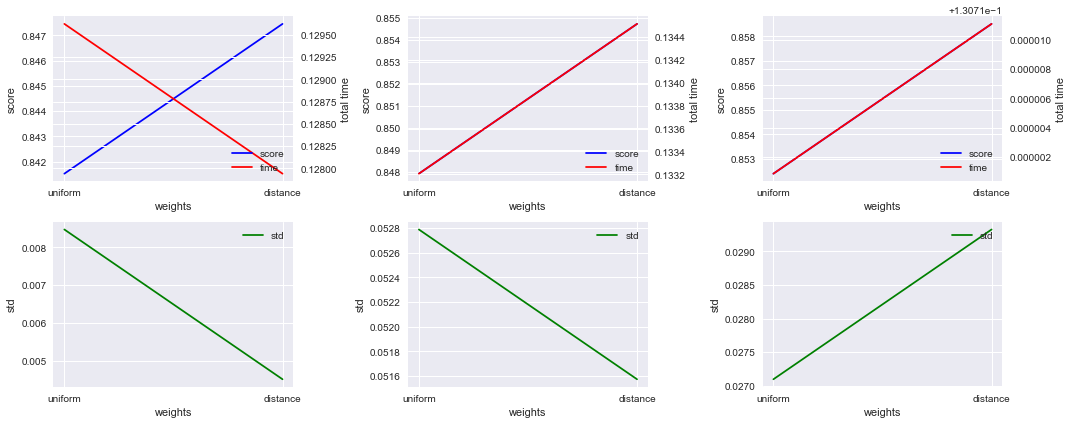

In [17]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    knn = KNeighborsClassifier(n_jobs=-1)
    parameters = {
        'n_neighbors': [40],
        'weights': ['uniform', 'distance']
    }
    cv = GridSearchCV(knn, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'weights'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = [0, 1]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xticks(x)
    ax1_line1.set_xticklabels(['uniform', 'distance'])
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xticks(x)
    ax1_line2.set_xticklabels(['uniform', 'distance'])
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [8]:
# predict
test_X = test_sheet.drop(['bidder_id'], axis=1)
result_sheet = pd.DataFrame(data=test_sheet['bidder_id'], columns=['bidder_id'])

df = KNeighborsClassifier(n_neighbors=40, weights='distance', n_jobs=-1)
df.fit(X, y)

result_sheet['prediction'] = pd.DataFrame(df.predict_proba(test_X))[1]
output = pd.merge(test, result_sheet, on='bidder_id', how='left').fillna(0)

In [47]:
file_name = 'output_0603_knn'
output.to_csv('result/' + file_name + '.csv', index=False)

# random forest

Best predict score for random state 15: 0.9077554998607631
Best parameter n_estimators: 210
Best predict score for random state 233: 0.8912832716375816
Best parameter n_estimators: 530
Best predict score for random state 1024: 0.9136616827909704
Best parameter n_estimators: 300


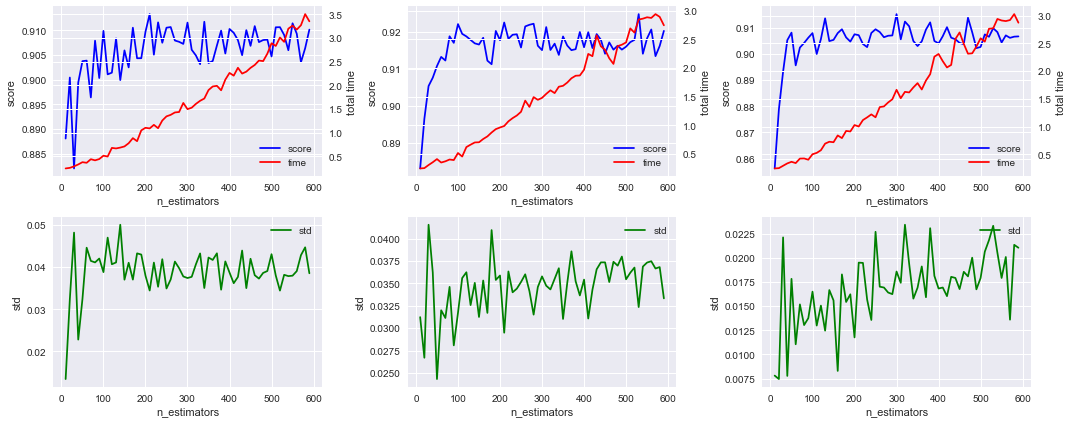

In [19]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    rf = RandomForestClassifier(n_jobs=-1)
    parameters = {
        'n_estimators': range(10, 600, 10)
    }
    cv = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'n_estimators'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.906641604010025
Best parameter criterion: entropy
Best predict score for random state 233: 0.9075445090780891
Best parameter criterion: entropy
Best predict score for random state 1024: 0.8811931984755204
Best parameter criterion: gini


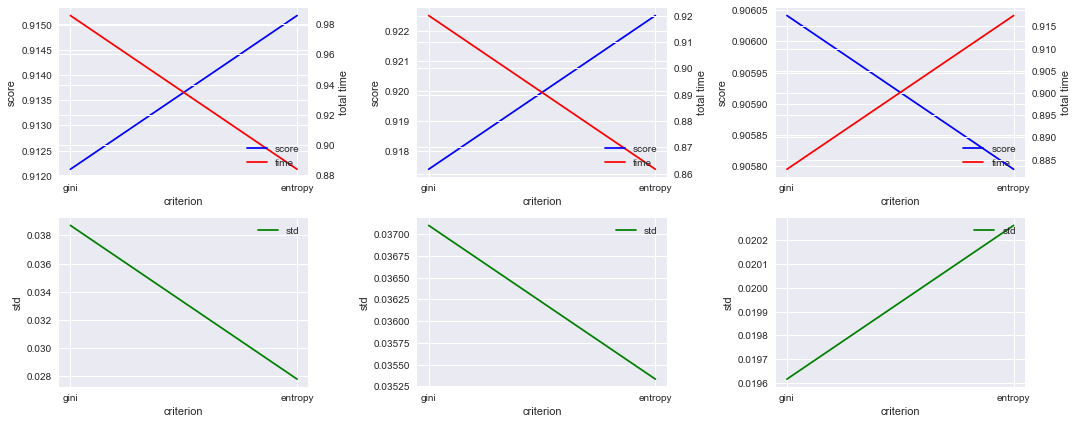

In [20]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    rf = RandomForestClassifier(n_jobs=-1)
    parameters = {
        'n_estimators': [500],
        'criterion': ['gini', 'entropy']
    }
    cv = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'criterion'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = [0, 1]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xticks(x)
    ax1_line1.set_xticklabels(['gini', 'entropy'])
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xticks(x)
    ax1_line2.set_xticklabels(['gini', 'entropy'])
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9160401002506267
Best parameter max_features: 18
Best predict score for random state 233: 0.8979375991538868
Best parameter max_features: 30
Best predict score for random state 1024: 0.9173995895631779
Best parameter max_features: 46


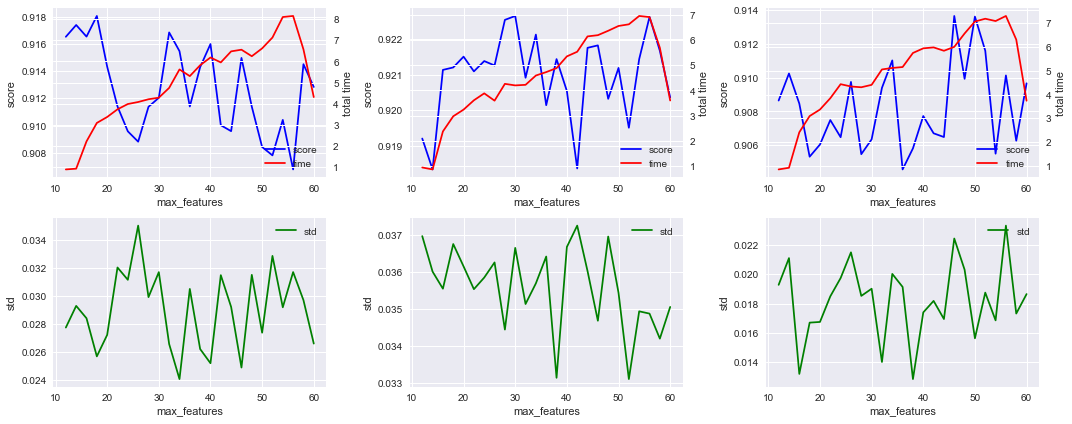

In [21]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    rf = RandomForestClassifier(n_jobs=-1)
    parameters = {
        'n_estimators': [500],
        'criterion': ['entropy'],
        'max_features': range(12, 62, 2)
    }
    cv = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'max_features'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9220272904483431
Best parameter max_depth: 91
Best predict score for random state 233: 0.9015952758681474
Best parameter max_depth: 11
Best predict score for random state 1024: 0.9094107299912049
Best parameter max_depth: 11


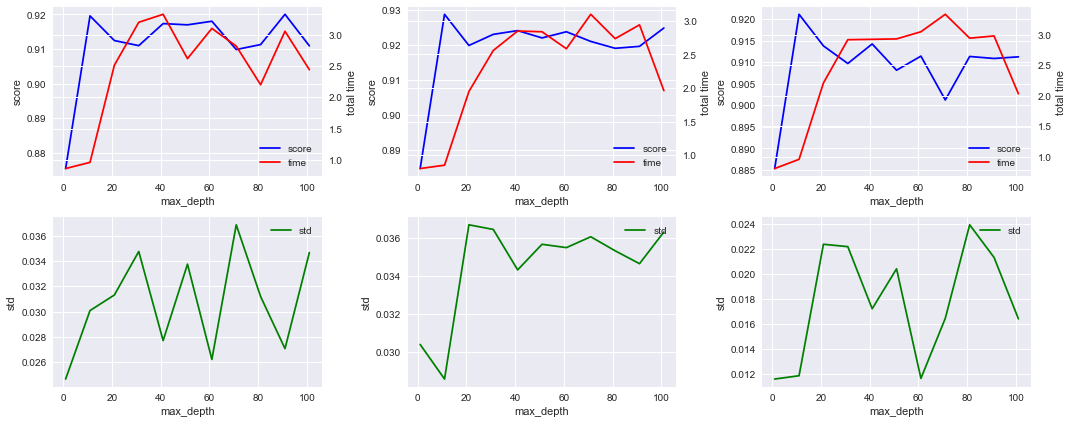

In [24]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    rf = RandomForestClassifier(n_jobs=-1)
    parameters = {
        'n_estimators': [500],
        'criterion': ['entropy'],
        'max_depth': range(1, 110, 10)
    }
    cv = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'max_depth'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9321915900863269
Best parameter max_depth: 4
Best predict score for random state 233: 0.901022386744227
Best parameter max_depth: 6
Best predict score for random state 1024: 0.9034007622398124
Best parameter max_depth: 5


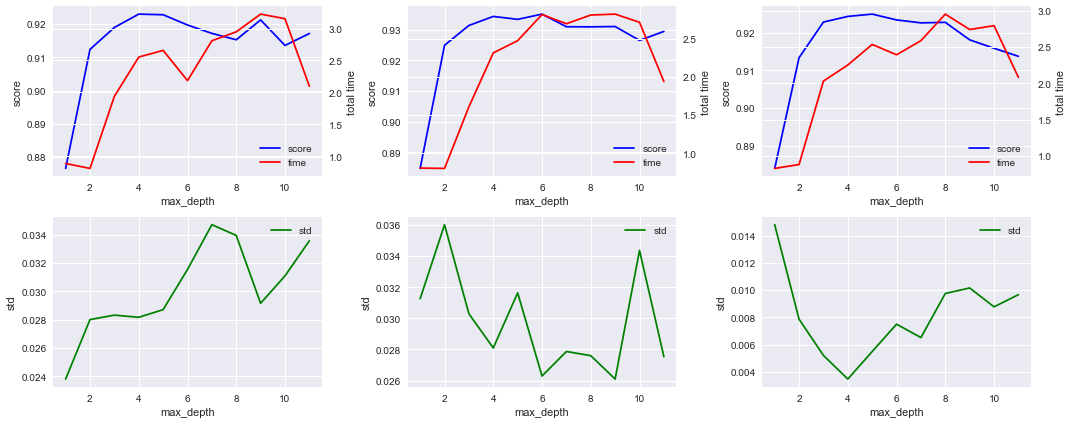

In [26]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    rf = RandomForestClassifier(n_jobs=-1)
    parameters = {
        'n_estimators': [500],
        'criterion': ['entropy'],
        'max_depth': range(1, 12)
    }
    cv = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'max_depth'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9346978557504872
Best parameter min_samples_split: 15
Best predict score for random state 233: 0.9019918914154768
Best parameter min_samples_split: 11
Best predict score for random state 1024: 0.8994429785986513
Best parameter min_samples_split: 19


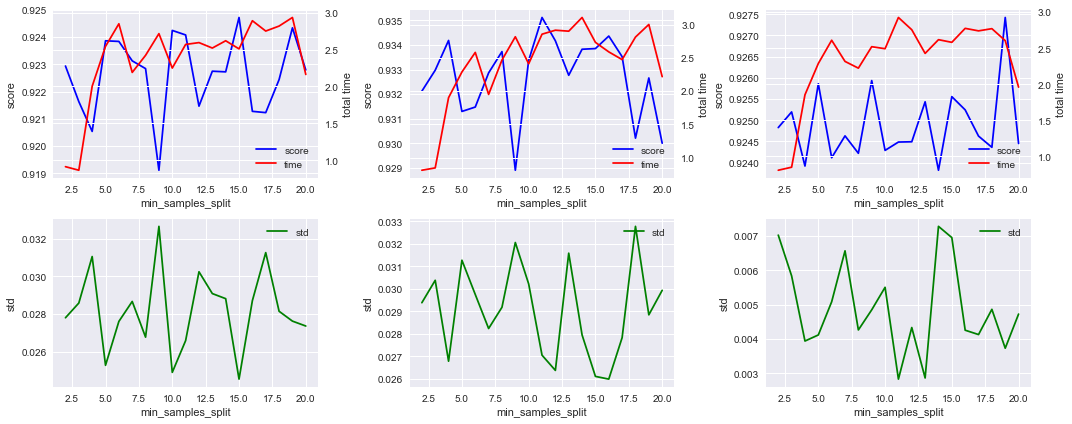

In [29]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    rf = RandomForestClassifier(n_jobs=-1)
    parameters = {
        'n_estimators': [500],
        'criterion': ['entropy'],
        'max_depth': [4],
        'min_samples_split': range(2, 21)
    }
    cv = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'min_samples_split'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9330270119743804
Best parameter min_samples_leaf: 2
Best predict score for random state 233: 0.9008461131676362
Best parameter min_samples_leaf: 5
Best predict score for random state 1024: 0.9034007622398124
Best parameter min_samples_leaf: 4


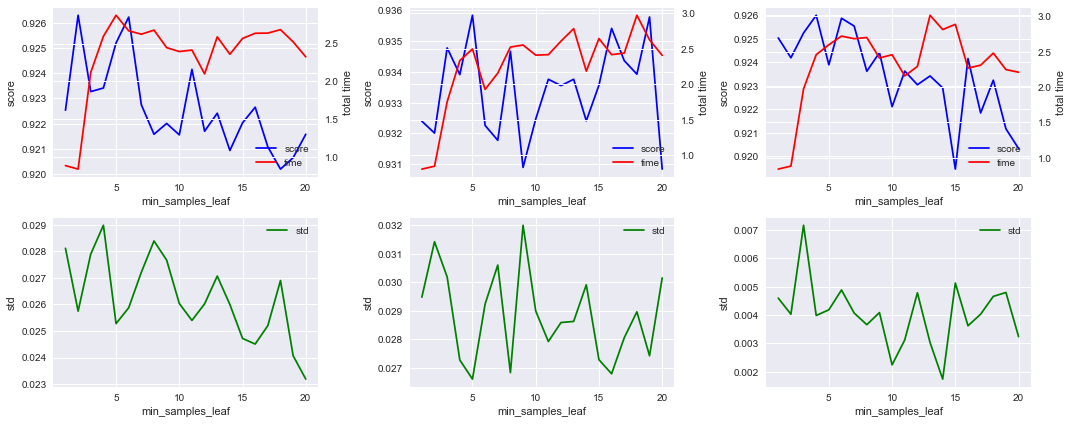

In [31]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    rf = RandomForestClassifier(n_jobs=-1)
    parameters = {
        'n_estimators': [500],
        'criterion': ['entropy'],
        'max_depth': [4],
        'min_samples_split': [10],
        'min_samples_leaf': range(1, 21)
    }
    cv = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'min_samples_leaf'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [8]:
# predict
test_X = test_sheet.drop(['bidder_id'], axis=1)
result_sheet = pd.DataFrame(data=test_sheet['bidder_id'], columns=['bidder_id'])

df = RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=4, min_samples_split=10, min_samples_leaf=5)
df.fit(X, y)

result_sheet['prediction'] = pd.DataFrame(df.predict_proba(test_X))[1]
output = pd.merge(test, result_sheet, on='bidder_id', how='left').fillna(0)

In [22]:
features = pd.Series(data=df.feature_importances_, index=X.columns)
features_print = features[features == 0]
arg_features = texts.columns
print('The useless features are: ')
for index, value in features_print.iteritems():
    print(str(index), end=', ')

print('\n')
print('The useless features are (args excluded): ')
for index, value in features_print.iteritems():
    if index not in arg_features:
        print(str(index), end=', ')

The useless features are: 
merch_nuni, merch_p_max, merch_p_min, merch_p_mean, merch_p_std, t_dif_auc_min_min, cty_auc_p_max_max, ip_auc_p_max_max, am, ar, at, auto parts, az, ba, bd, bf, bg, bh, bn, books and music, br, ca, ch, cl, clothing, cm, co, computers, cz, de, dj, dk, dz, eg, es, et, eu, fi, fr, furniture, ge, gh, gm, gt, hk, ie, il, iq, ir, it, jo, jp, ke, kg, kr, kw, lk, lu, ma, me, mk, mr, mt, mw, mx, mz, na, nl, no, np, om, pa, pe, pk, pl, py, qa, ro, rs, ru, sa, sd, se, sg, sk, so, sv, sz, tn, tr, tw, tz, ua, uk, unknown, vn, ye, zm, zw, 

The useless features are (args excluded): 
merch_nuni, merch_p_max, merch_p_min, merch_p_mean, merch_p_std, t_dif_auc_min_min, cty_auc_p_max_max, ip_auc_p_max_max, 

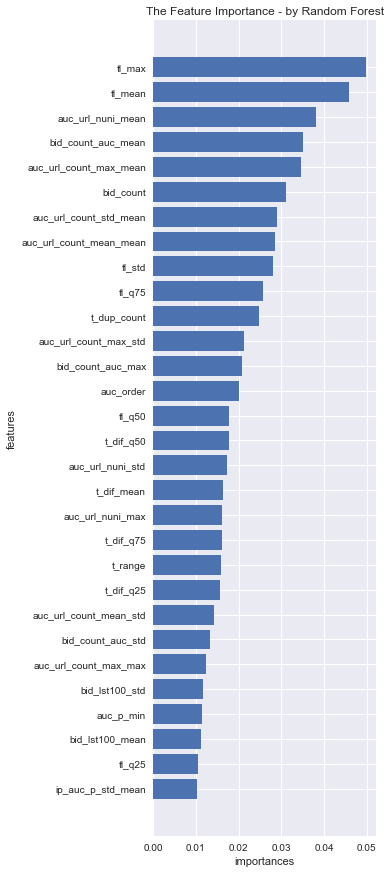

In [56]:
features = pd.Series(data=df.feature_importances_, index=X.columns)
features_plot = features[features > 0.01].sort_values()

plt.figure(figsize=(4, 15), facecolor='w')
plt.barh(range(len(features_plot)), features_plot)
plt.yticks(range(len(features_plot)), features_plot.index)
plt.ylabel('features')
plt.xlabel('importances')
plt.title('The Feature Importance - by Random Forest')
plt.show()

In [36]:
file_name = 'output_0603_rf'
output.to_csv('result/' + file_name + '.csv', index=False)

# lightGBM

Best predict score for random state 15: 0.9217488164856587
Best parameter n_estimators: 40
Best predict score for random state 233: 0.9035783536047948
Best parameter n_estimators: 40
Best predict score for random state 1024: 0.8940193491644678
Best parameter n_estimators: 60


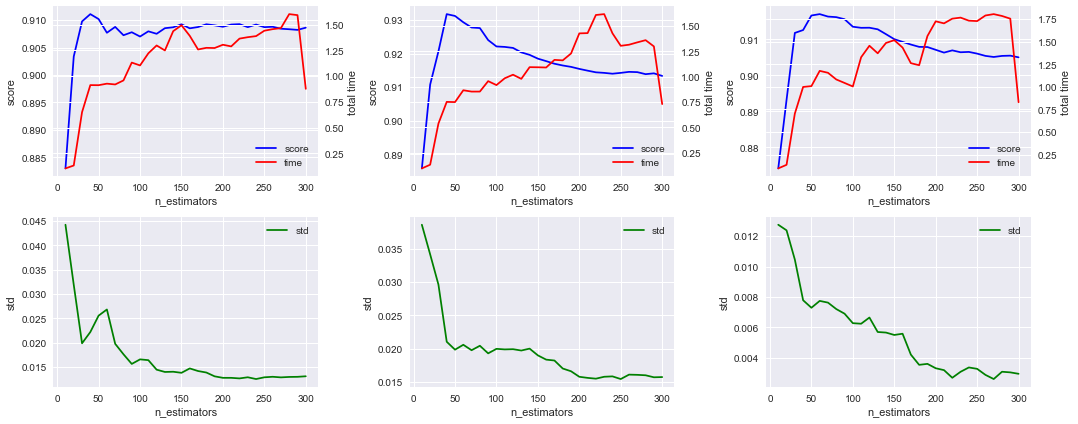

In [64]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': range(10, 310, 10)
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'n_estimators'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9221665274296853
Best parameter num_leaves: 2
Best predict score for random state 233: 0.8957782478406486
Best parameter num_leaves: 4
Best predict score for random state 1024: 0.8931398416886543
Best parameter num_leaves: 4


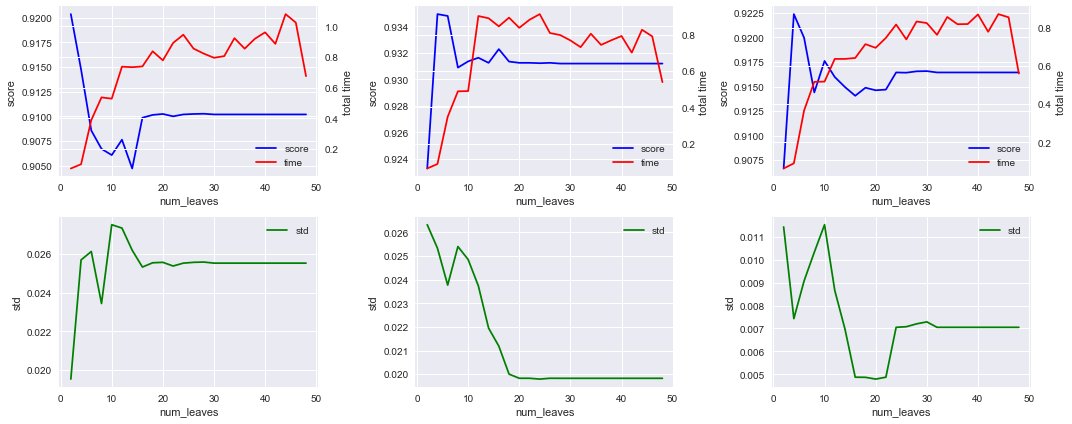

In [65]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': [50],
        'num_leaves': range(2, 50, 2)
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'num_leaves'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9342801448064606
Best parameter max_bin: 300
Best predict score for random state 233: 0.9006698395910453
Best parameter max_bin: 200
Best predict score for random state 1024: 0.8962914101436529
Best parameter max_bin: 700


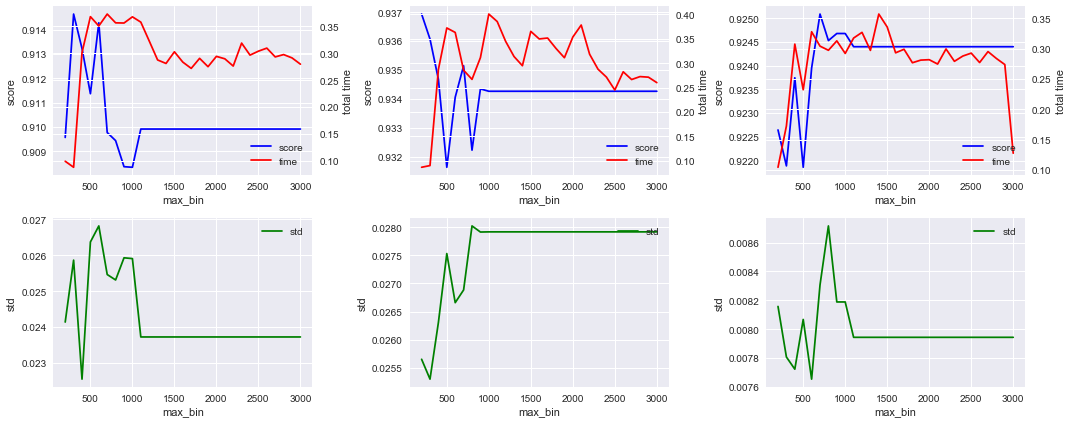

In [66]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': [50],
        'num_leaves': [4],
        'max_bin': range(200, 3100, 100)
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'max_bin'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9360902255639099
Best parameter is_unbalance: False
Best predict score for random state 233: 0.8957782478406486
Best parameter is_unbalance: False
Best predict score for random state 1024: 0.8931398416886543
Best parameter is_unbalance: False


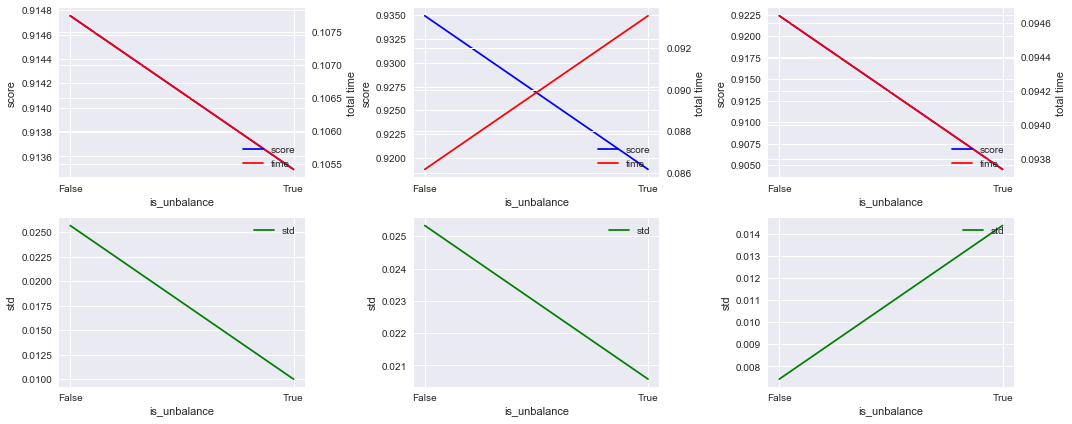

In [67]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': [50],
        'num_leaves': [4],
        'is_unbalance': [False, True]
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'is_unbalance'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = [0,1]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xticks(x)
    ax1_line1.set_xticklabels(['False', 'True'])
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xticks(x)
    ax1_line2.set_xticklabels(['False', 'True'])
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9360902255639099
Best parameter boosting_type: gbdt
Best predict score for random state 233: 0.8957782478406486
Best parameter boosting_type: gbdt
Best predict score for random state 1024: 0.8931398416886543
Best parameter boosting_type: gbdt


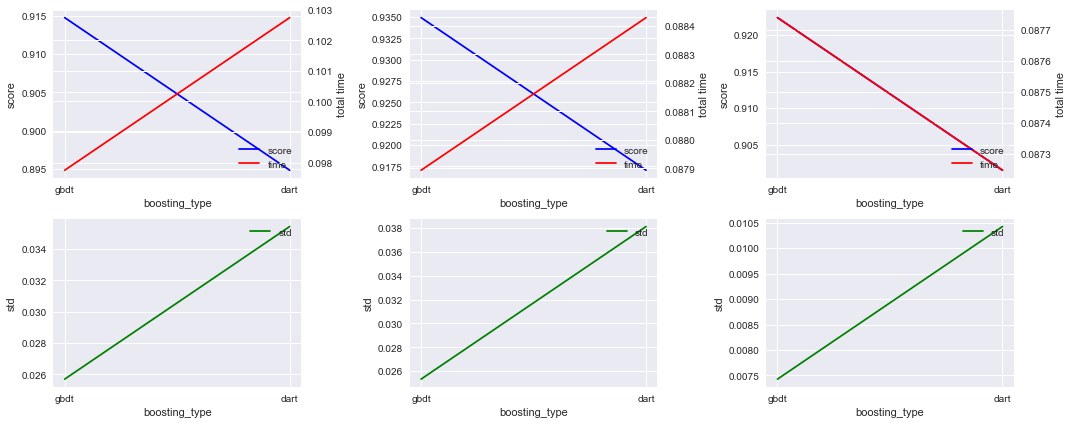

In [68]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': [50],
        'num_leaves': [4],
        'boosting_type': ['gbdt', 'dart']
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'boosting_type'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = [0,1]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xticks(x)
    ax1_line1.set_xticklabels(['gbdt', 'dart'])
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xticks(x)
    ax1_line2.set_xticklabels(['gbdt', 'dart'])
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9360902255639099
Best parameter learning_rate: 0.09999999999999999
Best predict score for random state 233: 0.8910188612726953
Best parameter learning_rate: 0.09
Best predict score for random state 1024: 0.8931398416886543
Best parameter learning_rate: 0.09999999999999999


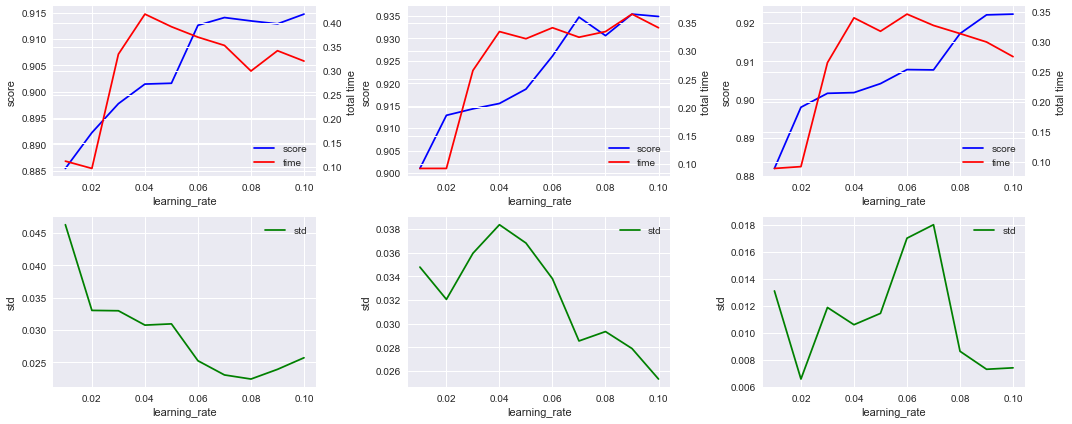

In [69]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': [50],
        'num_leaves': [4],
        'learning_rate': np.arange(0.01, 0.11, 0.01)
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'learning_rate'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9313561681982735
Best parameter min_child_weight: 7
Best predict score for random state 233: 0.892296844702979
Best parameter min_child_weight: 3
Best predict score for random state 1024: 0.8968044561712105
Best parameter min_child_weight: 1


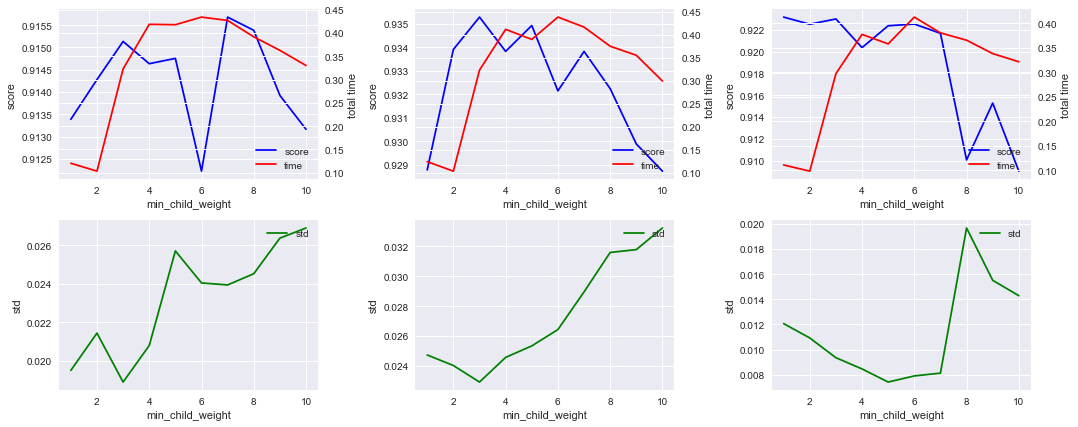

In [70]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': [50],
        'num_leaves': [4],
        'min_child_weight': range(1, 11)
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'min_child_weight'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Best predict score for random state 15: 0.9358117516012253
Best parameter min_child_samples: 14
Best predict score for random state 233: 0.891195134849286
Best parameter min_child_samples: 18
Best predict score for random state 1024: 0.8915274113163295
Best parameter min_child_samples: 2


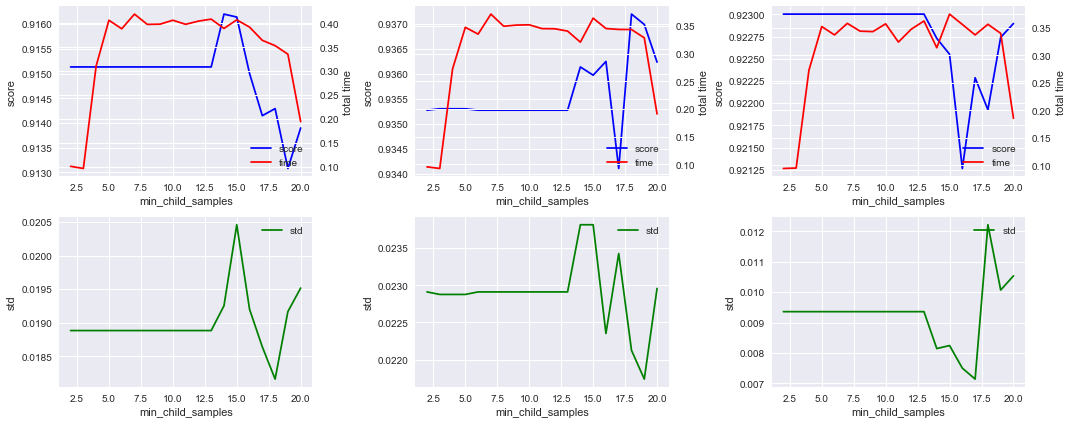

In [72]:
rand = [15, 233, 1024]
fig = plt.figure(figsize=(15, 6), facecolor='w')
for i in range(len(rand)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand[i])
    gbm = lgb.LGBMClassifier()
    parameters = {
        'n_estimators': [50],
        'num_leaves': [4],
        'min_child_weight': [3],
        'min_child_samples': range(2, 21)
    }
    cv = GridSearchCV(gbm, parameters, n_jobs=-1, scoring='roc_auc')
    cv.fit(X_train, y_train)
    print('Best predict score for random state {}: {}'.format(rand[i], cv.score(X_test, y_test)))
    tuning_key = 'min_child_samples'
    tuning_value = cv.best_params_[tuning_key]
    print('Best parameter {}: {}'.format(tuning_key, tuning_value))
    
    sheet = pd.DataFrame(cv.cv_results_)
    x_label = tuning_key
    x = sheet['param_' + x_label]
    y1 = sheet['mean_test_score']
    y2 = sheet['mean_fit_time'] + sheet['mean_score_time']
    y3 = sheet['std_test_score']
    y1_label = 'score'
    y2_label = 'total time'
    y3_label = 'std'
    # score and time
    sub_first = 231 + i
    ax1_line1 = fig.add_subplot(sub_first)
    ax2 = ax1_line1.twinx()
    handle2, = ax2.plot(x, y2, 'r', label='time')
    handle1, = ax1_line1.plot(x, y1, 'b', label='score')
    ax1_line1.set_xlabel(x_label)
    ax1_line1.set_ylabel(y1_label)
    ax2.set_ylabel(y2_label)
    plt.legend(handles=[handle1, handle2], loc=4, bbox_to_anchor=(1, 0))
    # std
    sub_second = 234 + i
    ax1_line2 = fig.add_subplot(sub_second)
    handle3, = ax1_line2.plot(x, y3, 'g', label='std')
    ax1_line2.set_xlabel(x_label)
    ax1_line2.set_ylabel(y3_label)
    plt.legend(handles=[handle3], loc=1, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [73]:
# predict
test_X = test_sheet.drop(['bidder_id'], axis=1)
result_sheet = pd.DataFrame(data=test_sheet['bidder_id'], columns=['bidder_id'])

df = lgb.LGBMClassifier(n_estimators=50, num_leaves=4, min_child_weight=3)
df.fit(X, y)

result_sheet['prediction'] = pd.DataFrame(df.predict_proba(test_X))[1]
output = pd.merge(test, result_sheet, on='bidder_id', how='left').fillna(0)

In [75]:
file_name = 'output_0603_lgb'
output.to_csv('result/' + file_name + '.csv', index=False)